# 1 初始化

## 1.1 导入包

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from tqdm import tqdm
import logging

log_fmt = "[%(asctime)s] %(levelname)s in %(module)s: %(message)s"
logging.basicConfig(format=log_fmt, level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

## 1.2 超参数定义

In [2]:
base_path = '/home/zengrui/datasets/190829_Kanshan_zjfx'

def save_param(param, param_name):
    with open(f'{base_path}/temp/{param_name}.txt', 'wb') as f:
        pickle.dump(param, f)
        
def read_param(param_name):
    with open(f'{base_path}/temp/{param_name}.txt', 'rb') as f:
        return pickle.load(f)

## 1.3 函数定义

In [3]:
def extract_day(s):
    return s.apply(lambda x: int(x.split('-')[0][1:]))


def extract_hour(s):
    return s.apply(lambda x: int(x.split('-')[1][1:]))

# 2 加载、处理数据

## 2.1 加载邀请回答数据

In [4]:
train = pd.read_csv(f'{base_path}/invite_info_0926.txt', sep='\t', header=None)
train.columns = ['qid', 'uid', 'dt', 'label']
logging.info("invite %s", train.shape)

test = pd.read_csv(f'{base_path}/invite_info_evaluate_1_0926.txt', sep='\t', header=None)
test.columns = ['qid', 'uid', 'dt']
logging.info("test %s", test.shape)

sub = test.copy()

sub_size = len(sub)

train['day'] = extract_day(train['dt'])
train['hour'] = extract_hour(train['dt'])

test['day'] = extract_day(test['dt'])
test['hour'] = extract_hour(test['dt'])

del train['dt'], test['dt']

[2019-12-08 19:47:07,117] INFO in <ipython-input-4-7a2c6478cb9e>: invite (9489162, 4)
[2019-12-08 19:47:08,473] INFO in <ipython-input-4-7a2c6478cb9e>: test (1141683, 3)


## 2.2 加载问题

丢弃了**问题info**的字词编码。

In [5]:
ques = pd.read_csv(f'{base_path}/question_info_0926.txt', header=None, sep='\t')
ques.columns = ['qid', 'q_dt', 'title_t1', 'title_t2', 'desc_t1', 'desc_t2', 'topic']
del ques['title_t1'], ques['title_t2'], ques['desc_t1'], ques['desc_t2']
logging.info("ques %s", ques.shape)

ques['q_day'] = extract_day(ques['q_dt'])
ques['q_hour'] = extract_hour(ques['q_dt'])
del ques['q_dt']

[2019-12-08 19:47:43,935] INFO in <ipython-input-5-958902b92fc5>: ques (1829900, 3)


## 2.3 加载回答

丢弃了**回答info**的字词编码，并与**问题info**合并。

In [6]:
ans = pd.read_csv(f'{base_path}/answer_info_0926.txt', header=None, sep='\t')
ans.columns = ['aid', 'qid', 'uid', 'ans_dt', 'ans_t1', 'ans_t2', 'is_good', 'is_rec', 'is_dest', 'has_img',
               'has_video', 'word_count', 'reci_cheer', 'reci_uncheer', 'reci_comment', 'reci_mark', 'reci_tks',
               'reci_xxx', 'reci_no_help', 'reci_dis']
del ans['ans_t1'], ans['ans_t2']
logging.info("ans %s", ans.shape)

ans['a_day'] = extract_day(ans['ans_dt'])
ans['a_hour'] = extract_hour(ans['ans_dt'])
del ans['ans_dt']

ans = pd.merge(ans, ques, on='qid')
del ques

[2019-12-08 19:49:07,146] INFO in <ipython-input-6-935311f5f359>: ans (4513735, 18)


## 2.4 处理时间数据

回答距提问的天数。

In [7]:
ans['diff_qa_days'] = ans['a_day'] - ans['q_day']

时间窗口划分。

In [8]:
train_start = 3838
train_end = 3867

val_start = 3868
val_end = 3874

label_end = 3867
label_start = label_end - 6

train_label_feature_end = label_end - 7
train_label_feature_start = train_label_feature_end - 22

train_ans_feature_end = label_end - 7
train_ans_feature_start = train_ans_feature_end - 50

val_label_feature_end = val_start - 1
val_label_feature_start = val_label_feature_end - 22

val_ans_feature_end = val_start - 1
val_ans_feature_start = val_ans_feature_end - 50

train_label_feature = train[(train['day'] >= train_label_feature_start) & (train['day'] <= train_label_feature_end)]
logging.info("train_label_feature %s", train_label_feature.shape)

val_label_feature = train[(train['day'] >= val_label_feature_start) & (train['day'] <= val_label_feature_end)]
logging.info("val_label_feature %s", val_label_feature.shape)

train_label = train[(train['day'] > train_label_feature_end)]

logging.info("train feature start %s end %s, label start %s end %s", train_label_feature['day'].min(),
             train_label_feature['day'].max(), train_label['day'].min(), train_label['day'].max())

logging.info("test feature start %s end %s, label start %s end %s", val_label_feature['day'].min(),
             val_label_feature['day'].max(), test['day'].min(), test['day'].max())

[2019-12-08 19:49:23,626] INFO in <ipython-input-8-5c7aac178bca>: train_label_feature (6895493, 5)
[2019-12-08 19:49:24,206] INFO in <ipython-input-8-5c7aac178bca>: val_label_feature (7583553, 5)
[2019-12-08 19:49:24,448] INFO in <ipython-input-8-5c7aac178bca>: train feature start 3838 end 3860, label start 3861 end 3867
[2019-12-08 19:49:24,473] INFO in <ipython-input-8-5c7aac178bca>: test feature start 3845 end 3867, label start 3868 end 3874


```python
print(train_label_feature_start, train_label_feature_end)
print(train_ans_feature_start, train_ans_feature_end)
print(val_label_feature_start, val_label_feature_end)
print(val_ans_feature_start, val_ans_feature_end)
```
```text
3838 3860
3810 3860
3845 3867
3817 3867
```

确定ans的时间范围。

In [9]:
train_ans_feature = ans[(ans['a_day'] >= train_ans_feature_start) & (ans['a_day'] <= train_ans_feature_end)]

val_ans_feature = ans[(ans['a_day'] >= val_ans_feature_start) & (ans['a_day'] <= val_ans_feature_end)]

logging.info("train ans feature %s, start %s end %s", train_ans_feature.shape, train_ans_feature['a_day'].min(),
             train_ans_feature['a_day'].max())

logging.info("val ans feature %s, start %s end %s", val_ans_feature.shape, val_ans_feature['a_day'].min(),
             val_ans_feature['a_day'].max())

fea_cols = ['is_good', 'is_rec', 'is_dest', 'has_img', 'has_video', 'word_count',
            'reci_cheer', 'reci_uncheer', 'reci_comment', 'reci_mark', 'reci_tks',
            'reci_xxx', 'reci_no_help', 'reci_dis', 'diff_qa_days']

[2019-12-08 19:49:28,135] INFO in <ipython-input-9-502ad99fdbbb>: train ans feature (3700178, 23), start 3810 end 3860
[2019-12-08 19:49:28,146] INFO in <ipython-input-9-502ad99fdbbb>: val ans feature (3992334, 23), start 3817 end 3867


## 2.5 特征提取

测试学习。

In [10]:
df = pd.DataFrame({'A' : ['foo', 'bar', 'foo', 'bar',
                      'foo', 'bar', 'foo', 'foo'],
                   'B' : ['one', 'one', 'two', 'three',
                          'two', 'two', 'one', 'three'],
                   'C' : np.random.randn(8),
                   'D' : np.random.randn(8)})
df

,A,B,C,D
0,foo,one,1.595226,-1.550317
1,bar,one,-0.319827,-0.058757
2,foo,two,0.059721,1.446469
3,bar,three,-0.666550,-1.731562
4,foo,two,-0.175375,-0.514370
5,bar,two,1.054923,-1.631197
6,foo,one,0.482194,-1.176911
7,foo,three,0.141436,-0.406015


In [11]:
[x for x in df.groupby('A')['D']]

[('bar', 1   -0.058757
  3   -1.731562
  5   -1.631197
  Name: D, dtype: float64), ('foo', 0   -1.550317
  2    1.446469
  4   -0.514370
  6   -1.176911
  7   -0.406015
  Name: D, dtype: float64)]

正式开始。

In [12]:
def extract_feature1(target, label_feature, ans_feature):
    # 问题特征
    t1 = label_feature.groupby('qid')['label'].agg(['mean', 'sum', 'std', 'count', 
                                                    'max', 'min']).reset_index()
    t1.columns = ['qid', 'q_inv_mean', 'q_inv_sum', 'q_inv_std', 'q_inv_count', 
                  'q_inv_max', 'q_inv_min']
    target = pd.merge(target, t1, on='qid', how='left')

    # 用户特征
    t1 = label_feature.groupby('uid')['label'].agg(['mean', 'sum', 'std', 'count', 
                                                    'max', 'min']).reset_index()
    t1.columns = ['uid', 'u_inv_mean', 'u_inv_sum', 'u_inv_std', 'u_inv_count', 
                  'u_inv_max', 'u_inv_min']
    target = pd.merge(target, t1, on='uid', how='left')
    #
    # train_size = len(train)
    # data = pd.concat((train, test), sort=True)

    # 回答部分特征

    t1 = ans_feature.groupby('qid')['aid'].count().reset_index()
    t1.columns = ['qid', 'q_ans_count']
    target = pd.merge(target, t1, on='qid', how='left')

    t1 = ans_feature.groupby('uid')['aid'].count().reset_index()
    t1.columns = ['uid', 'u_ans_count']
    target = pd.merge(target, t1, on='uid', how='left')

    for col in fea_cols:
        t1 = ans_feature.groupby('uid')[col].agg(['sum', 'max', 'mean', 
                                                  'std', 'count', 'min']).reset_index()
        t1.columns = ['uid', f'u_{col}_sum', f'u_{col}_max', f'u_{col}_mean',
                      f'u_{col}_std', f'u_{col}_count', f'u_{col}_min']
        target = pd.merge(target, t1, on='uid', how='left')

        t1 = ans_feature.groupby('qid')[col].agg(['sum', 'max', 'mean',
                                                  'std', 'count', 'min']).reset_index()
        t1.columns = ['qid', f'q_{col}_sum', f'q_{col}_max', f'q_{col}_mean',
                      f'q_{col}_std', f'q_{col}_count', f'q_{col}_min']
        target = pd.merge(target, t1, on='qid', how='left')
        logging.info("extract %s", col)
    return target


train_label = extract_feature1(train_label, train_label_feature, train_ans_feature)
test = extract_feature1(test, val_label_feature, val_ans_feature)

[2019-12-08 19:50:10,151] INFO in <ipython-input-12-0304f9fa763e>: extract is_good
[2019-12-08 19:50:23,376] INFO in <ipython-input-12-0304f9fa763e>: extract is_rec
[2019-12-08 19:50:37,461] INFO in <ipython-input-12-0304f9fa763e>: extract is_dest
[2019-12-08 19:50:51,629] INFO in <ipython-input-12-0304f9fa763e>: extract has_img
[2019-12-08 19:51:06,564] INFO in <ipython-input-12-0304f9fa763e>: extract has_video
[2019-12-08 19:51:20,618] INFO in <ipython-input-12-0304f9fa763e>: extract word_count
[2019-12-08 19:51:37,017] INFO in <ipython-input-12-0304f9fa763e>: extract reci_cheer
[2019-12-08 19:51:53,490] INFO in <ipython-input-12-0304f9fa763e>: extract reci_uncheer
[2019-12-08 19:52:10,381] INFO in <ipython-input-12-0304f9fa763e>: extract reci_comment
[2019-12-08 19:52:26,593] INFO in <ipython-input-12-0304f9fa763e>: extract reci_mark
[2019-12-08 19:52:42,952] INFO in <ipython-input-12-0304f9fa763e>: extract reci_tks
[2019-12-08 19:52:59,368] INFO in <ipython-input-12-0304f9fa763e>: 

特征提取结束。

In [13]:
logging.info("train shape %s, test shape %s", train_label.shape, test.shape)
assert len(test) == sub_size

[2019-12-08 19:57:08,396] INFO in <ipython-input-13-6bad7a600272>: train shape (2593669, 199), test shape (1141683, 198)


## 2.6 加载用户

In [14]:
user = pd.read_csv(f'{base_path}/member_info_0926.txt', header=None, sep='\t')
user.columns = ['uid', 'gender', 'creat_keyword', 'level', 'hot', 'reg_type', 'reg_plat', 'freq', 'uf_b1', 'uf_b2',
                'uf_b3', 'uf_b4', 'uf_b5', 'uf_c1', 'uf_c2', 'uf_c3', 'uf_c4', 'uf_c5', 'score', 'follow_topic',
                'inter_topic']
del user['follow_topic'], user['inter_topic']
logging.info("user %s", user.shape)

unq = user.nunique()
logging.info("user unq %s", unq)

for x in unq[unq == 1].index:
    del user[x]
    logging.info('del unq==1 %s', x)

t = user.dtypes
cats = [x for x in t[t == 'object'].index if x not in ['follow_topic', 'inter_topic', 'uid']]
logging.info("user cat %s", cats)

for d in cats:
    lb = LabelEncoder()
    user[d] = lb.fit_transform(user[d])
    logging.info('encode %s', d)

q_lb = LabelEncoder()
q_lb.fit(list(train_label['qid'].astype(str).values) + list(test['qid'].astype(str).values))
train_label['qid_enc'] = q_lb.transform(train_label['qid'])
test['qid_enc'] = q_lb.transform(test['qid'])

u_lb = LabelEncoder()
u_lb.fit(user['uid'])
train_label['uid_enc'] = u_lb.transform(train_label['uid'])
test['uid_enc'] = u_lb.transform(test['uid'])

[2019-12-08 19:57:17,749] INFO in <ipython-input-14-f4f8e8f0ac9b>: user (1931654, 19)
[2019-12-08 19:57:20,814] INFO in <ipython-input-14-f4f8e8f0ac9b>: user unq uid              1931654
gender                 3
creat_keyword          1
level                  1
hot                    1
reg_type               1
reg_plat               1
freq                   5
uf_b1                  2
uf_b2                  2
uf_b3                  2
uf_b4                  2
uf_b5                  2
uf_c1               2561
uf_c2                291
uf_c3                428
uf_c4               1556
uf_c5                  2
score                732
dtype: int64
[2019-12-08 19:57:20,844] INFO in <ipython-input-14-f4f8e8f0ac9b>: del unq==1 creat_keyword
[2019-12-08 19:57:20,849] INFO in <ipython-input-14-f4f8e8f0ac9b>: del unq==1 level
[2019-12-08 19:57:20,850] INFO in <ipython-input-14-f4f8e8f0ac9b>: del unq==1 hot
[2019-12-08 19:57:21,074] INFO in <ipython-input-14-f4f8e8f0ac9b>: del unq==1 reg_type
[2019

merge user

In [15]:
train_label = pd.merge(train_label, user, on='uid', how='left')
test = pd.merge(test, user, on='uid', how='left')
logging.info("train shape %s, test shape %s", train_label.shape, test.shape)

[2019-12-08 19:57:57,349] INFO in <ipython-input-15-a0af6fdcbd8e>: train shape (2593669, 214), test shape (1141683, 213)


及时清理内存。

In [16]:
del ans, train_label_feature, train_ans_feature, val_label_feature, val_ans_feature, user

In [17]:
data = pd.concat((train_label, test), axis=0, sort=True)
len_train_label = len(train_label)

# 暂存清理变量
save_param(train_label, 'train_label')
del train_label
del test

count编码。

In [18]:
data

,day,freq,gender,hour,label,q_ans_count,q_diff_qa_days_count,q_diff_qa_days_max,q_diff_qa_days_mean,q_diff_qa_days_min,...,uf_b3,uf_b4,uf_b5,uf_c1,uf_c2,uf_c3,uf_c4,uf_c5,uid,uid_enc
0,3865,4,2,22,0.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,2113,190,261,927,1,M401693808,1508098
1,3862,4,2,15,0.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,1519,229,0,506,1,M2317670257,657985
2,3867,1,2,4,0.0,32.0,32.0,13.0,9.531250,0.0,...,0,0,0,551,226,188,815,1,M3544409350,1272353
3,3861,0,1,20,0.0,3.0,3.0,234.0,222.333333,215.0,...,0,0,0,1519,229,0,506,1,M2818659842,909154
4,3862,4,0,8,1.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,2161,31,396,1438,1,M848334644,1856019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1141678,3869,4,2,20,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,1459,190,79,758,1,M2010778235,504328
1141679,3872,1,2,21,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,1190,130,119,758,1,M3131383616,1066117
1141680,3871,0,2,15,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,184,142,311,758,1,M1872860897,435860
1141681,3871,4,2,8,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,1190,130,6,1373,1,M3574631517,1287650


In [20]:
save_param(data, 'data')

MemoryError: 

In [22]:
count_fea = ['uid_enc', 'qid_enc', 'gender', 'freq', 'uf_c1', 'uf_c2', 'uf_c3', 'uf_c4', 'uf_c5']
with tqdm(total=len(count_fea)) as pbar:
    for feat in count_fea:
        col_name = '{}_count'.format(feat)
        data[col_name] = data[feat].map(data[feat].value_counts().astype(int))
        data.loc[data[col_name] < 2, feat] = -1
        data[feat] += 1
        data[col_name] = data[feat].map(data[feat].value_counts().astype(int))
        data[col_name] = (data[col_name] - data[col_name].min()) / (data[col_name].max() - data[col_name].min())
        pbar.update(1)

  0%|          | 0/9 [00:00<?, ?it/s]


MemoryError: 

## 2.7 处理数据

压缩数据。

In [ ]:
t = data.dtypes
for x in t[t == 'int64'].index:
    data[x] = data[x].astype('int32')

for x in t[t == 'float64'].index:
    data[x] = data[x].astype('float32')

data['wk'] = data['day'] % 7

feature_cols = [x for x in data.columns if x not in ('label', 'uid', 'qid', 'dt', 'day')]

target编码。

In [ ]:
logging.info("feature size %s", len(feature_cols))

# 恢复数据
train_label = read_param('train_label')
    
X_train_all = data.iloc[:len_train_label][feature_cols]
y_train_all = data.iloc[:len_train_label]['label']

test = data.iloc[len_train_label:]
# with open(f'{base_path}/temp/test.txt', 'wb') as f:
#     pickle.dump(test, f)
#     del test
    
assert len(data) - len_train_label == sub_size

# 3 训练树

## 3.1 预处理数据

In [ ]:
logging.info("train shape %s, test shape %s", 
             data.iloc[:len_train_label].shape, 
             data.iloc[len_train_label:].shape)

save_param(data, 'data')
del data


# 分层采样，交叉验证（切分5片）
fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# 但只用了其中一次切片
for index, (train_idx, val_idx) in enumerate(fold.split(X=X_train_all, y=y_train_all)):
    break

X_train, X_val, y_train, y_val = X_train_all.iloc[train_idx][feature_cols], X_train_all.iloc[val_idx][feature_cols], \
                                 y_train_all.iloc[train_idx], \
                                 y_train_all.iloc[val_idx]
# del X_train_all

## 3.2 存取数据

存变量

In [ ]:
import pickle

save_param(X_train, 'X_train')
save_param(y_train, 'y_train')
save_param(X_val, 'X_val')
save_param(y_val, 'y_val')
save_param(test, 'test')
save_param(sub, 'sub')
save_param(X_train_all, 'X_train_all')
save_param(y_train_all, 'y_train_all')
save_param(feature_cols, 'feature_cols')

取变量

In [3]:
import pickle

X_train = read_param('X_train')
y_train = read_param('y_train')
X_val = read_param('X_val')
y_val = read_param('y_val')
test = read_param('test')
sub = read_param('sub')
X_train_all = read_param('X_train_all')
y_train_all = read_param('y_train_all')
feature_cols = read_param('feature_cols')

## 3.3 LGBM分类器训练

In [ ]:
X_train

In [7]:
del model_lgb

In [6]:
model_lgb = LGBMClassifier(n_estimators=2000, 
                           n_jobs=6, 
                           objective='binary', 
                           seed=1000, 
                           silent=True)
model_lgb.fit(X_train, y_train,
              eval_metric=['logloss', 'auc'],
              eval_set=[(X_val, y_val)],
              early_stopping_rounds=50)

[1]	valid_0's auc: 0.694659	valid_0's binary_logloss: 0.43264
Training until validation scores don't improve for 50 rounds
[2]	valid_0's auc: 0.69746	valid_0's binary_logloss: 0.427194
[3]	valid_0's auc: 0.699562	valid_0's binary_logloss: 0.422871
[4]	valid_0's auc: 0.700995	valid_0's binary_logloss: 0.419338
[5]	valid_0's auc: 0.702133	valid_0's binary_logloss: 0.416435
[6]	valid_0's auc: 0.703	valid_0's binary_logloss: 0.414084
[7]	valid_0's auc: 0.703621	valid_0's binary_logloss: 0.412139
[8]	valid_0's auc: 0.704017	valid_0's binary_logloss: 0.410473
[9]	valid_0's auc: 0.704995	valid_0's binary_logloss: 0.40902
[10]	valid_0's auc: 0.705465	valid_0's binary_logloss: 0.407792
[11]	valid_0's auc: 0.70591	valid_0's binary_logloss: 0.406748


KeyboardInterrupt: 

In [24]:
save_param(model_lgb, 'model_lgb')

## 3.4 换用神经网络训练

### 3.4.1 导入包

In [38]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Activation, BatchNormalization, Dense, Dropout

import os
import tensorflow as tf
from keras.backend import set_session

BATCH_SIZE = 8192
EPOCHS = 5
LR = 0.01

os.environ["CUDA_VISIBLE_DEVICES"] = "3"
config = tf.compat.v1.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.8  # 占用GPU百分比
config.gpu_options.allow_growth = True
set_session(tf.compat.v1.Session(config=config)) # 此处不同

### 3.4.2 数据处理

过采样均衡数据。

In [12]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

logging.info('y_train distribution is %s' % Counter(y_train))
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
logging.info('y_resampled distribution is %s' % Counter(y_resampled))

[2019-12-06 14:52:22,133] INFO in <ipython-input-12-d16766aa9ee7>: y_train distribution is Counter({0.0: 1742924, 1.0: 332010})
[2019-12-06 14:52:41,135] INFO in <ipython-input-12-d16766aa9ee7>: y_resampled distribution is Counter({0.0: 1742924, 1.0: 1742924})


归一化数据。

In [15]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
x = X_resampled.values
x = mms.fit_transform(x)
X_resampled = pd.DataFrame(x)
X_resampled

,0,1,2,3,4,5,6,7,8,9,...,116,117,118,119,120,121,122,123,124,125
0,1.00,1.000000,1.0,1.00000,0.956522,NaN,NaN,NaN,NaN,NaN,...,0.370162,0.612150,0.220357,0.596401,0.063075,1.0,1.0,0.780729,0.000000,0.166667
1,1.00,1.000000,1.0,1.00000,0.652174,NaN,NaN,NaN,NaN,NaN,...,0.111176,0.002336,0.444174,0.325835,0.004092,1.0,1.0,0.340633,0.000003,0.833333
2,0.25,0.726702,1.0,1.00000,0.173913,0.012205,0.007429,0.007670,0.000110,1.0,...,0.034051,0.441589,0.403767,0.524422,0.044312,1.0,1.0,0.658686,0.000015,0.500000
3,0.00,0.979042,0.5,0.37587,0.869565,0.000787,0.078811,0.076444,0.000216,1.0,...,0.111176,0.002336,0.444174,0.325835,0.004092,1.0,1.0,0.470661,0.000003,0.666667
4,1.00,1.000000,0.0,0.00000,0.347826,NaN,NaN,NaN,NaN,NaN,...,0.007531,0.927570,0.514839,0.924807,0.125055,1.0,1.0,0.960845,0.000027,0.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3485843,0.25,0.726702,0.0,0.00000,0.434783,NaN,NaN,NaN,NaN,NaN,...,0.135960,0.280374,0.217955,0.487789,1.000000,1.0,1.0,0.703995,0.000000,0.000000
3485844,0.00,0.979042,0.5,0.37587,0.652174,NaN,NaN,NaN,NaN,NaN,...,0.135960,0.922897,0.629243,0.487789,1.000000,1.0,1.0,0.319920,0.000006,0.500000
3485845,0.25,0.726702,0.0,0.00000,0.347826,NaN,NaN,NaN,NaN,NaN,...,1.000000,0.002336,0.444174,0.487789,1.000000,1.0,1.0,0.025804,0.000018,0.333333
3485846,0.00,0.979042,1.0,1.00000,0.652174,NaN,NaN,NaN,NaN,NaN,...,1.000000,0.623832,0.511017,0.141388,0.005033,1.0,1.0,0.325498,0.000006,0.666667


### 3.4.3 定义训练模型

定义回调函数。

In [13]:
train_callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, 
                      patience=2, verbose=1, 
                      mode='auto', min_delta=0.0001, 
                      cooldown=0, min_lr=0,),  # lr scheduler
]

模型结构定义。

In [39]:
from keras.models import Sequential

del model
model = Sequential()

model.add(Dense(256, activation='tanh', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='linear'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 256)               32512     
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 256)              

优化器和损失函数定义。

In [40]:
from keras.optimizers import SGD

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### 3.4.4 开始训练

In [42]:
EPOCHS = 10

H = model.fit(X_resampled.values, y_resampled.values,
              batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=train_callbacks,
              validation_data=(X_val, y_val), shuffle=True,)

Train on 3485848 samples, validate on 518735 samples
Epoch 1/10
3485848/3485848 [==============================] - 21s 6us/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6935 - val_accuracy: 0.1600
Epoch 2/10
3485848/3485848 [==============================] - 20s 6us/step - loss: 0.6932 - accuracy: 0.5001 - val_loss: 0.6935 - val_accuracy: 0.1600
Epoch 3/10
3485848/3485848 [==============================] - 24s 7us/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6925 - val_accuracy: 0.8400
Epoch 4/10
3485848/3485848 [==============================] - 21s 6us/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6930 - val_accuracy: 0.8400
Epoch 5/10
3485848/3485848 [==============================] - 24s 7us/step - loss: 0.6932 - accuracy: 0.4997 - val_loss: 0.6926 - val_accuracy: 0.8400

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/10
3485848/3485848 [==============================] - 23s 7us/step - loss: 0.6932 - accuracy: 0.5000 -

KeyboardInterrupt: 

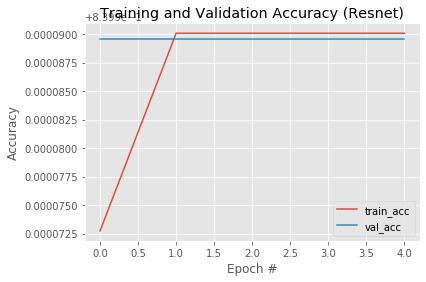

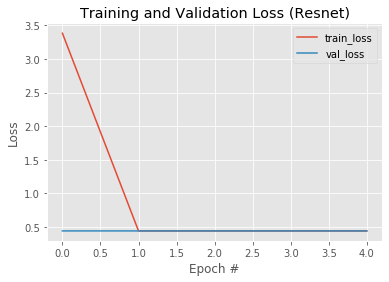

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt

# 绘制结果曲线

N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training and Validation Accuracy (Resnet)")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
# plt.savefig('./output/simple_nn_plot_acc.png')
 
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training and Validation Loss (Resnet)")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()
# plt.savefig('./output/simple_nn_plot_loss.png')

# 4 计算结果

In [25]:
# 恢复数据
test = read_param('test')

## 4.1 LGBM结果

In [26]:
sub['label'] = model_lgb.predict_proba(test[feature_cols])[:, 1]

In [27]:
sub.to_csv('./storage/result.txt', index=None, header=None, sep='\t')

## 4.2 神经网络结果

In [37]:
res = model.predict(test[feature_cols], batch_size=BATCH_SIZE)
res

array([[0.51117074],
       [0.51117074],
       [0.51117074],
       ...,
       [0.5111708 ],
       [0.5111708 ],
       [0.5111708 ]], dtype=float32)

In [87]:
test[feature_cols]

,freq,freq_count,gender,gender_count,hour,q_ans_count,q_diff_qa_days_max,q_diff_qa_days_mean,q_diff_qa_days_sum,q_has_img_max,...,uf_c2_count,uf_c3,uf_c3_count,uf_c4,uf_c4_count,uf_c5,uf_c5_count,uid_enc,uid_enc_count,wk
0,6,0.325453,4,0.0000,9,NaN,NaN,NaN,NaN,NaN,...,0.439214,203,0.479449,1376,0.000038,3,0.346068,1752473,0.000000,6
1,2,0.726702,4,0.0000,22,NaN,NaN,NaN,NaN,NaN,...,0.439214,396,0.456703,521,0.008534,3,0.346068,767938,0.000000,1
2,6,0.325453,2,0.4874,15,NaN,NaN,NaN,NaN,NaN,...,0.439214,205,0.083870,445,0.007599,3,0.346068,1147981,0.000009,3
3,5,1.000000,3,1.0000,4,4.0,11.0,3.0,12.0,0.0,...,0.439214,188,0.114102,1038,0.001950,2,1.000000,1372679,0.000015,2
4,6,0.325453,2,0.4874,19,NaN,NaN,NaN,NaN,NaN,...,0.168475,336,0.137013,788,0.001688,3,0.346068,1,0.297591,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1141678,6,0.325453,4,0.0000,20,NaN,NaN,NaN,NaN,NaN,...,0.168475,81,0.020067,760,0.434533,3,0.346068,504330,0.000000,5
1141679,3,0.118357,4,0.0000,21,NaN,NaN,NaN,NaN,NaN,...,0.439214,121,0.094249,760,0.434533,3,0.346068,1066119,0.000003,1
1141680,2,0.726702,4,0.0000,15,NaN,NaN,NaN,NaN,NaN,...,0.001308,313,0.056923,760,0.434533,3,0.346068,435862,0.000000,0
1141681,6,0.325453,4,0.0000,8,NaN,NaN,NaN,NaN,NaN,...,0.439214,8,0.442846,1375,0.031122,3,0.346068,1287652,0.000015,0
